In [1]:
import os
import cv2
import time
import argparse
import multiprocessing
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if tf.__version__ < '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')

C:\Users\hp\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from utils import label_map_util

from utils import visualization_utils as vis_util

C:\Users\hp\Desktop\Siemens\models\research\object_detection\utils\visualization_utils.py:25: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Users\hp\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\hp\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\hp\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\hp\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\Us

In [3]:
CWD_PATH = os.getcwd()

# Path to frozen detection graph. This is the actual model that is used for the object detection.
MODEL_NAME = 'siemens_graph'
PATH_TO_CKPT = os.path.join(CWD_PATH, MODEL_NAME, 'frozen_inference_graph.pb')

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join(CWD_PATH, 'training', 'object-detection.pbtxt')
print(PATH_TO_CKPT)
print(PATH_TO_LABELS)

C:\Users\hp\Desktop\Siemens\models\research\object_detection\siemens_graph\frozen_inference_graph.pb
C:\Users\hp\Desktop\Siemens\models\research\object_detection\training\object-detection.pbtxt


In [4]:
NUM_CLASSES = 3

# Loading label map
label_map = label_map_util.load_labelmap(os.path.join(PATH_TO_LABELS))
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES,
                                                            use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(category_index)

{1: {'id': 1, 'name': 'CB'}, 2: {'id': 2, 'name': 'CT'}, 3: {'id': 3, 'name': 'DIS'}}


In [5]:
def detect_objects(image_np, sess, detection_graph):
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

    # Each box represents a part of the image where a particular object was detected.
    boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    scores = detection_graph.get_tensor_by_name('detection_scores:0')
    #print(scores)
    classes = detection_graph.get_tensor_by_name('detection_classes:0')
    #print(classes)
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    #print(num_detections)

    # Actual detection.
    (boxes, scores, classes, num_detections) = sess.run(
        [boxes, scores, classes, num_detections],
        feed_dict={image_tensor: image_np_expanded})

    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        np.squeeze(boxes),
        np.squeeze(classes).astype(np.int32),
        np.squeeze(scores),
        category_index,
        use_normalized_coordinates=True,
        line_thickness=8)
    return image_np

In [6]:
# First test on images

PATH_TO_TEST_IMAGES_DIR = 'test_images_siemens'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 12) ]
#TEST_IMAGE_PATHS = "object_detection/test_images/image1.jpg"
print(TEST_IMAGE_PATHS)
# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

['test_images_siemens\\image1.jpg', 'test_images_siemens\\image2.jpg', 'test_images_siemens\\image3.jpg', 'test_images_siemens\\image4.jpg', 'test_images_siemens\\image5.jpg', 'test_images_siemens\\image6.jpg', 'test_images_siemens\\image7.jpg', 'test_images_siemens\\image8.jpg', 'test_images_siemens\\image9.jpg', 'test_images_siemens\\image10.jpg', 'test_images_siemens\\image11.jpg']


In [7]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

(129, 129) (129, 129, 3)
(128, 128) (128, 128, 3)
(123, 123) (123, 123, 3)
(66, 104) (104, 66, 3)
(128, 128) (128, 128, 3)
(128, 128) (128, 128, 3)
(256, 256) (256, 256, 3)
(128, 128) (128, 128, 3)
(128, 128) (128, 128, 3)
(91, 129) (129, 91, 3)
(58, 72) (72, 58, 3)


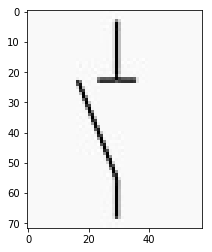

In [8]:
from PIL import Image
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    image_np = load_image_into_numpy_array(image)
    plt.imshow(image_np)
    print(image.size, image_np.shape)

In [9]:
#Load a frozen TF model 
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

(129, 129, 3)
(128, 128, 3)
(123, 123, 3)
(104, 66, 3)
(128, 128, 3)
(128, 128, 3)
(256, 256, 3)
(128, 128, 3)
(128, 128, 3)
(129, 91, 3)
(72, 58, 3)


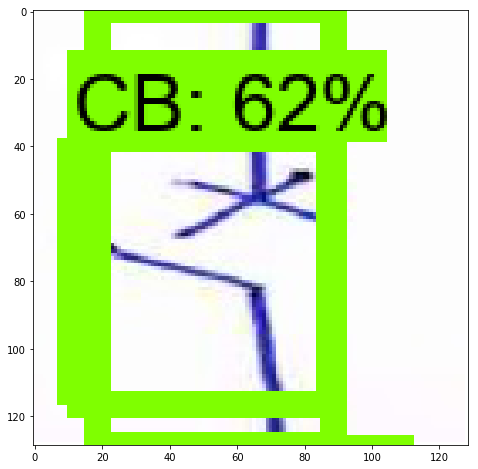

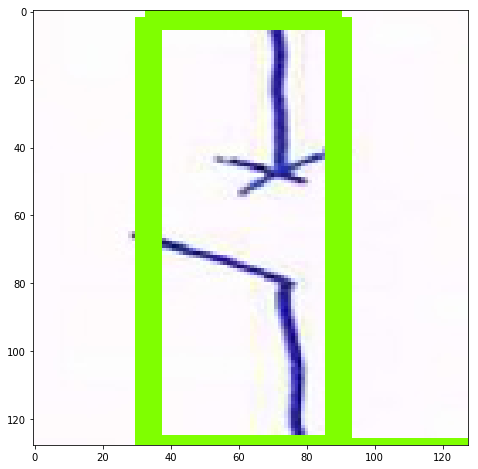

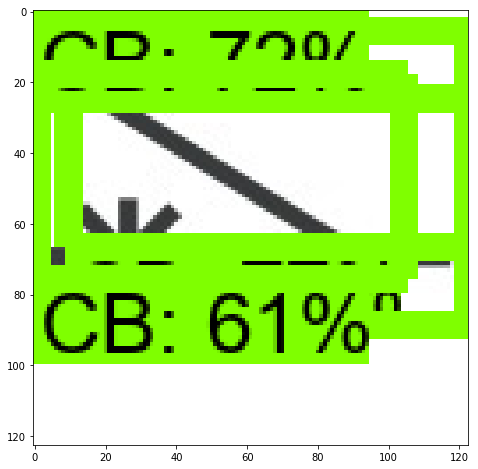

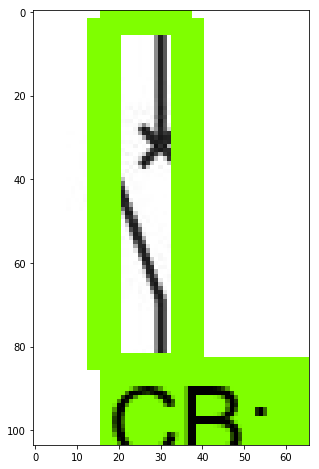

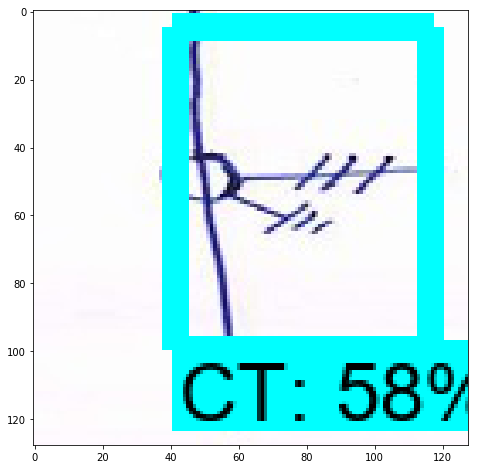

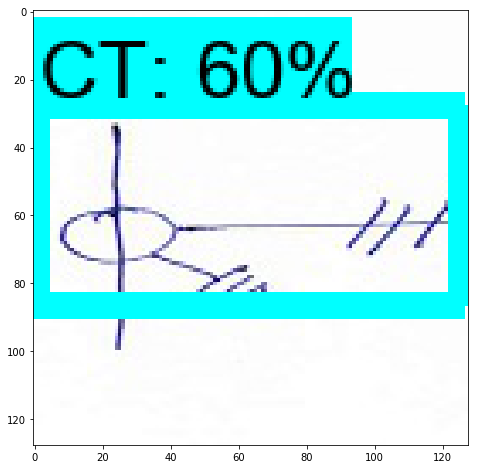

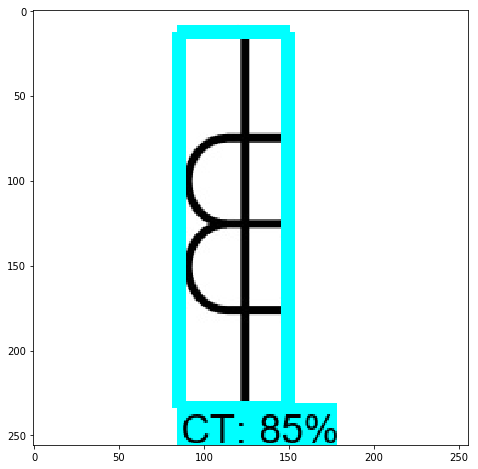

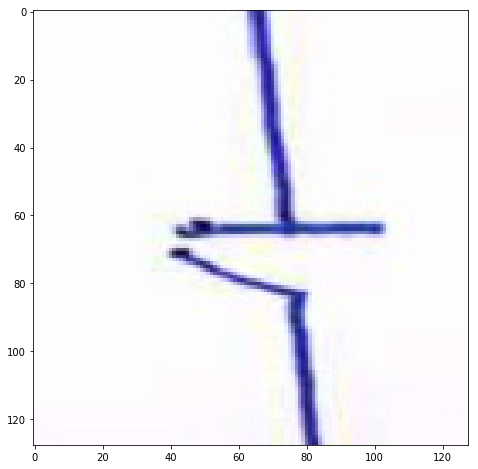

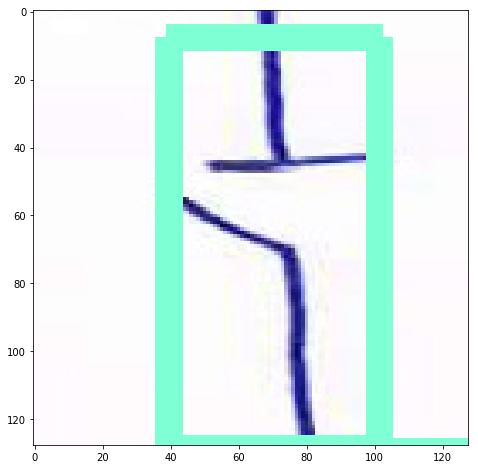

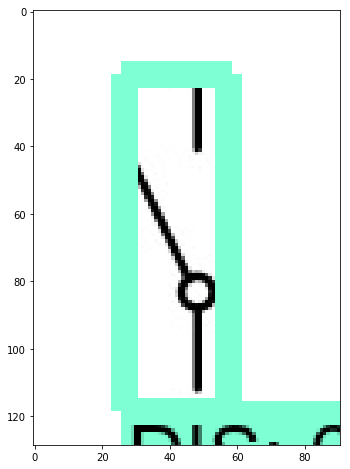

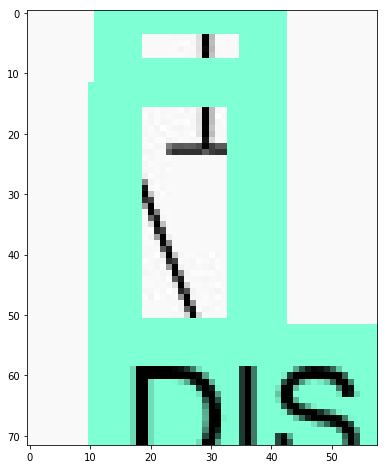

In [10]:
with  detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            image_np = load_image_into_numpy_array(image)
            image_process = detect_objects(image_np, sess, detection_graph)
            print(image_process.shape)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_process)

# Predicting Final image

In [11]:

PATH_TO_TEST_IMAGES_DIR = 'test_images_siemens'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(12, 15) ]
#TEST_IMAGE_PATHS = "object_detection/test_images/image1.jpg"
print(TEST_IMAGE_PATHS)
# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

['test_images_siemens\\image12.jpg', 'test_images_siemens\\image13.jpg', 'test_images_siemens\\image14.jpg']


In [12]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

(367, 471) (471, 367, 3)
(517, 265) (265, 517, 3)
(1028, 322) (322, 1028, 3)


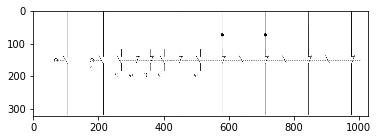

In [13]:
from PIL import Image
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    image_np = load_image_into_numpy_array(image)
    plt.imshow(image_np)
    print(image.size, image_np.shape)

In [14]:
#Load a frozen TF model 
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

(471, 367, 3)
(265, 517, 3)
(322, 1028, 3)


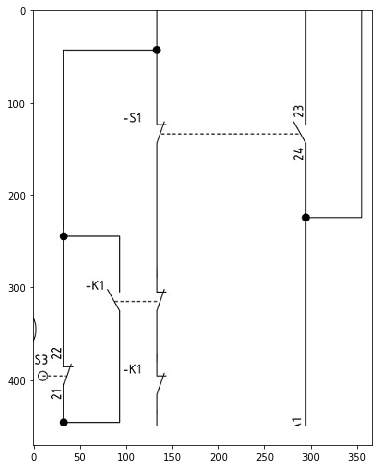

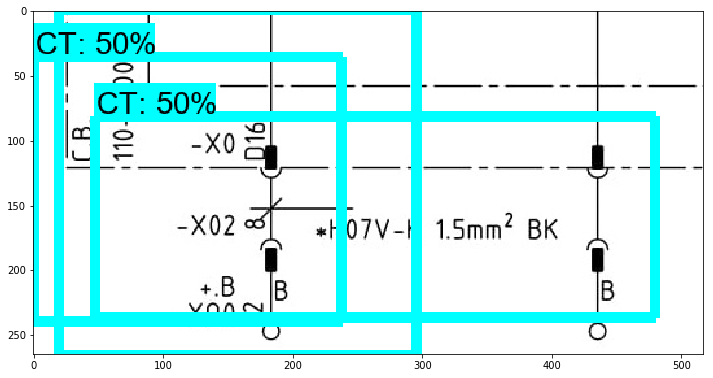

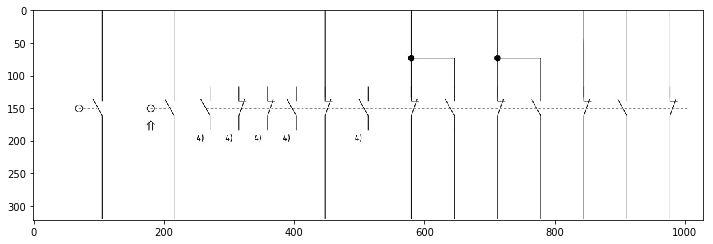

In [15]:
with  detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            image_np = load_image_into_numpy_array(image)
            image_process = detect_objects(image_np, sess, detection_graph)
            print(image_process.shape)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_process)